In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Label and Label Map

In [2]:
# Set the path to the data
DATA_PATH = os.path.join('MP_Data')

# Define the actions and label map
actions = np.array(['Hello', 'Namaste', 'My name is', 'Indian', 'Sign', 'Language', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'Hello': 0,
 'Namaste': 1,
 'My name is': 2,
 'Indian': 3,
 'Sign': 4,
 'Language': 5,
 'A': 6,
 'B': 7,
 'C': 8,
 'D': 9,
 'E': 10,
 'F': 11,
 'G': 12,
 'H': 13,
 'I': 14,
 'J': 15,
 'K': 16,
 'L': 17,
 'M': 18,
 'N': 19,
 'O': 20,
 'P': 21,
 'Q': 22,
 'R': 23,
 'S': 24,
 'T': 25,
 'U': 26,
 'V': 27,
 'W': 28,
 'X': 29,
 'Y': 30,
 'Z': 31}

# Sequencing and Tokenizing

In [3]:
# Define the sequence length and tokenization function
sequence_length = 30

def tokenize_sequence(sequence):
    return sequence  # No need to flatten, as the input is already a 1D array

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [4]:
# Convert sequences to tokenized format
tokenized_sequences = [tokenize_sequence(seq) for seq in sequences]

# Convert labels to one-hot encoded format
y = to_categorical(labels).astype(int)

# Convert the tokenized sequences and labels to NumPy arrays
X = np.array(tokenized_sequences)
y = np.array(y)

# Reshape the input data to be compatible with the Transformer model
# The input shape for the Transformer model should be (sequence_length, feature_dim)
# In this case, the feature_dim is 4, as each frame is represented by a 1D array of length 4
X = X.reshape(X.shape[0], sequence_length, -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Define the input shape for the Transformer model
input_shape = X_train.shape[1:]

In [5]:
# Check the shapes of the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Input shape for Transformer model:", input_shape)

X_train shape: (1520, 30, 258)
y_train shape: (1520, 32)
X_test shape: (80, 30, 258)
y_test shape: (80, 32)
Input shape for Transformer model: (30, 258)


# Build Model

In [6]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [8]:
def transformer_block(inputs, num_heads, head_size, ff_dim, dropout=0, l2=0):
    # Multi-head attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = layers.Dropout(dropout)(attention_output)
    # Residual connection
    attention_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    # Feed-forward layer with L2 regularization
    ff_output = layers.Dense(ff_dim, activation='relu', kernel_regularizer=regularizers.l2(l2))(attention_output)
    ff_output = layers.Dense(inputs.shape[-1], kernel_regularizer=regularizers.l2(l2))(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)
    # Residual connection
    ff_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + ff_output)
    return ff_output

def build_transformer_model(input_shape, num_heads, head_size, ff_dim, num_transformer_blocks, mlp_units, dropout=0, l2=0):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, num_heads, head_size, ff_dim, dropout, l2)
    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(actions.shape[0], activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

model = build_transformer_model(
    input_shape=(30, 258),
    num_heads=8,
    head_size=64,
    ff_dim=256,
    num_transformer_blocks=3,
    mlp_units=[64, 32],
    dropout=0.1,
    l2=0.01  # You can adjust the value of l2 regularization here
)

# Compile Model

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Model Summary

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 258)]    0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 30, 258)     530178      ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30, 258)      0           ['multi_head_attention[0][0]']   
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 30, 258)     0           ['input_1[0][0]',            

                                                                                                  
 dropout_7 (Dropout)            (None, 32)           0           ['dense_7[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 32)           1056        ['dropout_7[0][0]']              
                                                                                                  
Total params: 2,011,172
Trainable params: 2,011,172
Non-trainable params: 0
__________________________________________________________________________________________________


# Training Model

In [10]:
history=model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[tb_callback]
)


Epoch 1/100
48/48 [==============================] - 12s 185ms/step - loss: 19.7281 - accuracy: 0.0579 - val_loss: 18.8418 - val_accuracy: 0.1000
Epoch 2/100
48/48 [==============================] - 8s 173ms/step - loss: 18.1867 - accuracy: 0.1303 - val_loss: 17.1774 - val_accuracy: 0.2625
Epoch 3/100
48/48 [==============================] - 8s 173ms/step - loss: 16.7136 - accuracy: 0.2204 - val_loss: 15.6732 - val_accuracy: 0.4750
Epoch 4/100
48/48 [==============================] - 8s 172ms/step - loss: 15.4094 - accuracy: 0.3447 - val_loss: 14.4035 - val_accuracy: 0.5750
Epoch 5/100
48/48 [==============================] - 8s 172ms/step - loss: 14.2781 - accuracy: 0.4270 - val_loss: 13.3138 - val_accuracy: 0.6375
Epoch 6/100
48/48 [==============================] - 8s 174ms/step - loss: 13.2718 - accuracy: 0.5388 - val_loss: 12.2390 - val_accuracy: 0.8375
Epoch 7/100
48/48 [==============================] - 8s 174ms/step - loss: 12.3382 - accuracy: 0.6362 - val_loss: 11.3902 - val_a

Epoch 58/100
48/48 [==============================] - 9s 187ms/step - loss: 2.0068 - accuracy: 0.9618 - val_loss: 1.8213 - val_accuracy: 1.0000
Epoch 59/100
48/48 [==============================] - 8s 174ms/step - loss: 1.9257 - accuracy: 0.9711 - val_loss: 1.7841 - val_accuracy: 1.0000
Epoch 60/100
48/48 [==============================] - 9s 177ms/step - loss: 1.8566 - accuracy: 0.9770 - val_loss: 1.7323 - val_accuracy: 1.0000
Epoch 61/100
48/48 [==============================] - 9s 178ms/step - loss: 1.8136 - accuracy: 0.9783 - val_loss: 1.6812 - val_accuracy: 1.0000
Epoch 62/100
48/48 [==============================] - 9s 183ms/step - loss: 1.7816 - accuracy: 0.9724 - val_loss: 1.6705 - val_accuracy: 0.9875
Epoch 63/100
48/48 [==============================] - 9s 180ms/step - loss: 1.7464 - accuracy: 0.9776 - val_loss: 1.6037 - val_accuracy: 1.0000
Epoch 64/100
48/48 [==============================] - 8s 175ms/step - loss: 1.7147 - accuracy: 0.9730 - val_loss: 1.5759 - val_accuracy:

# Testing and Saving Model

In [11]:
res = model.predict(X_test)

3/3 [==============================] - 1s 54ms/step


In [12]:
actions[np.argmax(res[4])]

'K'

In [13]:
actions[np.argmax(y_test[4])]

'K'

In [28]:
model.save('ISL_1.h5')

# Evaluation

In [14]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [15]:
yhat = model.predict(X_test)

3/3 [==============================] - 0s 65ms/step


In [16]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [17]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[77,  0],
        [ 0,  3]],

       [[79,  0],
        [ 0,  1]],

       [[79,  0],
        [ 0,  1]],

       [[77,  0],
        [ 0,  3]],

       [[78,  0],
        [ 0,  2]],

       [[77,  0],
        [ 0,  3]],

       [[79,  0],
        [ 0,  1]],

       [[77,  0],
        [ 0,  3]],

       [[78,  0],
        [ 0,  2]],

       [[76,  0],
        [ 0,  4]],

       [[79,  0],
        [ 0,  1]],

       [[78,  0],
        [ 0,  2]],

       [[78,  0],
        [ 0,  2]],

       [[75,  0],
        [ 0,  5]],

       [[77,  0],
        [ 0,  3]],

       [[78,  0],
        [ 0,  2]],

       [[78,  0],
        [ 0,  2]],

       [[77,  0],
        [ 0,  3]],

       [[79,  0],
        [ 0,  1]],

       [[79,  0],
        [ 0,  1]],

       [[75,  0],
        [ 0,  5]],

       [[76,  0],
        [ 0,  4]],

       [[78,  0],
        [ 0,  2]],

       [[77,  0],
        [ 0,  3]],

       [[75,  0],
        [ 0,  5]],

       [[78,  0],
        [ 0,  2]],

       [[76,

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns

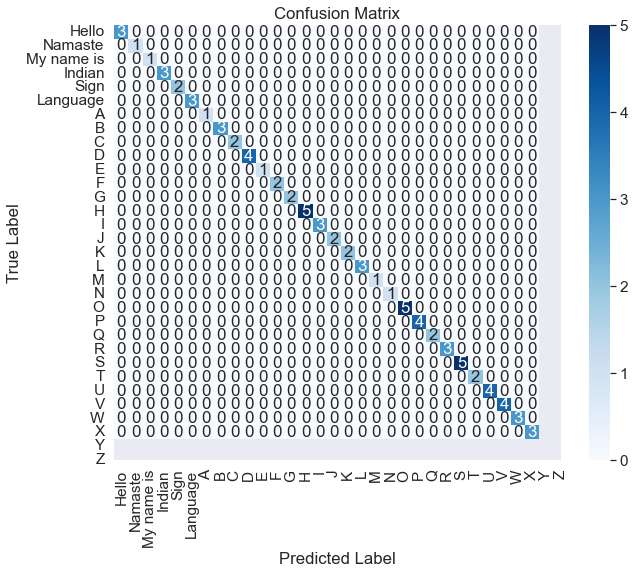

Accuracy : 1.0


In [20]:
# Confusion matrix
cm = confusion_matrix(ytrue, yhat)
class_labels = ['Hello', 'Namaste', 'My name is', 'Indian', 'Sign', 'Language', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
plt.figure(figsize=(10, 8))


sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy = accuracy_score(ytrue, yhat)
print("Accuracy :", accuracy)

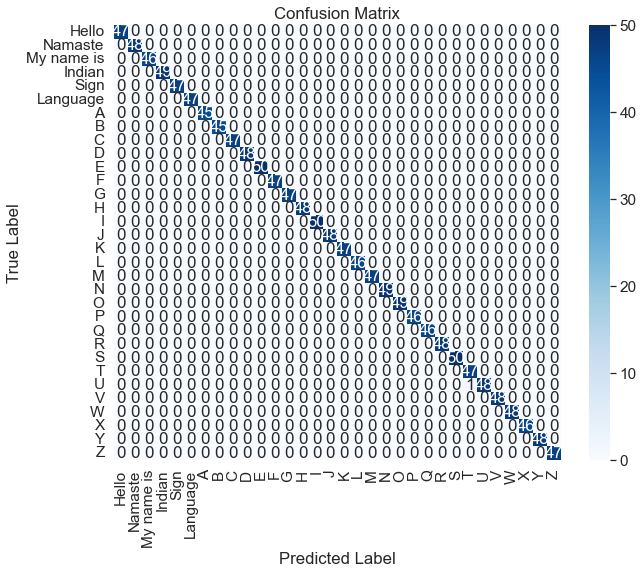

Accuracy : 0.9993421052631579


In [49]:
# Confusion matrix for training
cm = confusion_matrix(ytrue, yhat)
class_labels = ['Hello', 'Namaste', 'My name is', 'Indian', 'Sign', 'Language', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
plt.figure(figsize=(10, 8))


sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy = accuracy_score(ytrue, yhat)
print("Accuracy :", accuracy)

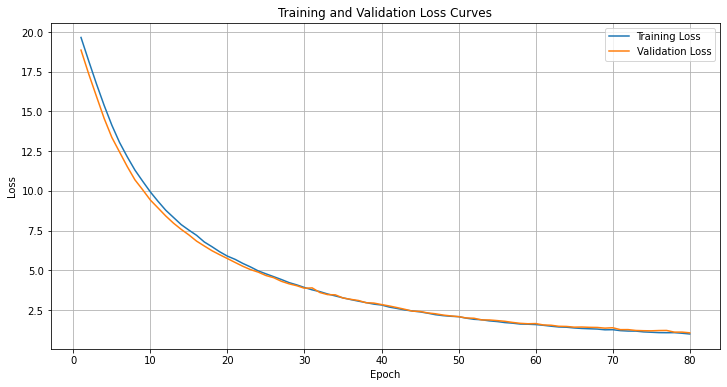

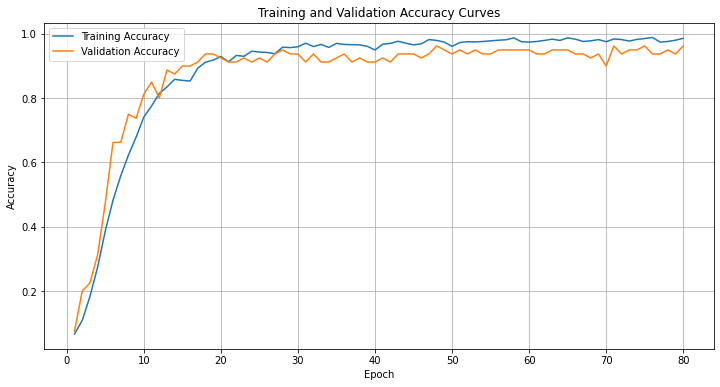

In [10]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and recorded the training history as shown above
# Get the loss and accuracy values for training and validation sets from the history

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid()
plt.show()

3/3 [==============================] - 0s 87ms/step


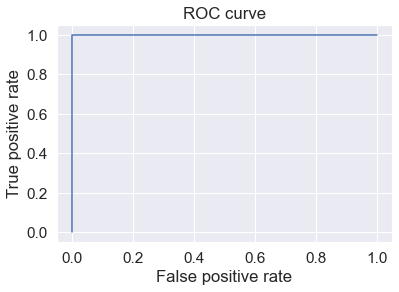

In [22]:
# ROC curves
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

3/3 [==============================] - 0s 18ms/step


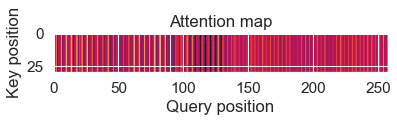

In [30]:
# Attention maps
attention_model = Model(inputs=model.input,
                        outputs=model.get_layer('multi_head_attention').output)
attention_weights = attention_model.predict(X_test)
# Plot the attention weights for the first example in the test set
plt.imshow(attention_weights[0])
plt.title('Attention map')
plt.xlabel('Query position')
plt.ylabel('Key position')
plt.show()